In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
cd /content/drive/MyDrive/faisal_exp

/content/drive/MyDrive/faisal_exp


In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
import pandas as pd
import numpy as np
X = pd.read_excel (r'/content/drive/MyDrive/faisal_exp/nir_specto.xlsx',header=None)
X = X.iloc[:,1:580] 
X=X[1:58]
X=np.array(X)
print(X.shape)


(57, 579)


In [ ]:
import pandas as pd
Y_p = pd.read_excel (r'/content/drive/MyDrive/faisal_exp/lab(%).xlsx')
Y_p = Y_p.iloc[:,1:8]
#Y_p = Y_p.iloc[:,2]
Y_p=np.array(Y_p)
print (Y_p.shape)


(57, 7)


In [ ]:
import pandas as pd
Y_c = pd.read_excel (r'/content/drive/MyDrive/faisal_exp/lab(content).xlsx')
Y_c = Y_c.iloc[:,2:9]
#Y_c = Y_c.iloc[:,2]
Y_c=np.array(Y_c)
print (Y_c.shape)



(57, 7)


In [ ]:
#Expand dataset, Function also available in ChemUtils
def dataaugment(x, betashift = 0.05, slopeshift = 0.05,multishift = 0.05):
    #Shift of baseline
    #calculate arrays
    beta = np.random.random(size=(x.shape[0],1))*2*betashift-betashift
    slope = np.random.random(size=(x.shape[0],1))*2*slopeshift-slopeshift + 1
    #Calculate relative position
    axis = np.array(range(x.shape[1]))/float(x.shape[1])
    #Calculate offset to be added
    offset = slope*(axis) + beta - axis - slope/2. + 0.5

    #Multiplicative
    multi = np.random.random(size=(x.shape[0],1))*2*multishift-multishift + 1

    x = multi*x + offset

    return x

In [ ]:
np.random.seed(0)

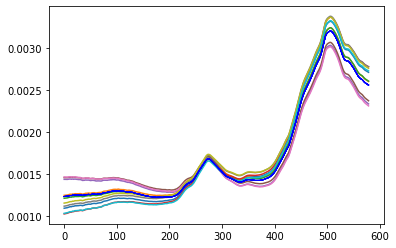

In [ ]:
#Data Augment a single spectrum
import numpy as np
from matplotlib import pyplot as plt
#First Spectrum
X_one = X[0:1]
#Repeating the spectrum 10x
X_one = np.repeat(X_one, repeats=10, axis=0)
#Augment (Large pertubations for illustration)
X_aug = dataaugment(X_one,betashift = 6.542472601263714e-05, slopeshift = 0.0005,multishift = 6.542472601263714e-05)
    
plt.plot(X_aug.T)
_= plt.plot(X_one.T, lw=1, c='b')

In [ ]:
shift = np.std(X)*0.1
shift

6.542472601263714e-05

171
171


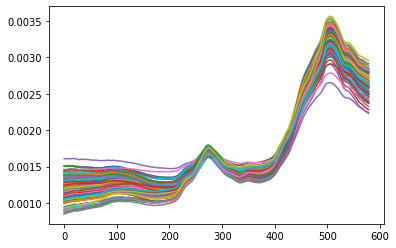

In [ ]:
X_train_aug = np.repeat(X, repeats=3, axis=0)
X_train_aug = dataaugment(X_train_aug, betashift = shift, slopeshift = 0.0005, multishift = shift)
# = s = np.random.normal(Y_mean, Y_std, 171)
y_train_aug = np.repeat(Y_c, repeats=3, axis=0) #y_train is simply repeated
#X_test_aug = np.repeat(X_test, repeats=10, axis=0)
#X_test_aug = dataaugment(X_test_aug, betashift = shift, slopeshift = 0.05, multishift = shift)

#y_test_aug = np.repeat(y_test, repeats=10, axis=0) #y_train is simply repeated


print (len(X_train_aug))
print (len(y_train_aug))
_ = plt.plot(X_train_aug[0:100].T)

In [ ]:
# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_aug, y_train_aug, test_size=0.30, random_state=42)
 
# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(119, 579)
(119, 7)
(52, 579)
(52, 7)


In [ ]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)
# fit scaler on training data
norm_lab = MinMaxScaler().fit(y_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)
# transform training label
Y_train_norm = norm_lab.transform(y_train)

# transform testing label
Y_test_norm = norm_lab.transform(y_test)

In [ ]:
#Rescale to NN friendly number range
from ChemUtils import GlobalStandardScaler

xscaler = GlobalStandardScaler()

#Calibrate is smaler than test, so they are swapped
X_train = xscaler.fit_transform(X_train) #From instrument 1
X_test=xscaler.transform(X_test)

In [ ]:
yscaler = GlobalStandardScaler()
y_train = yscaler.fit_transform( y_train)
y_test = yscaler.transform( y_test)  

In [ ]:
from sklearn.cross_decomposition import PLSRegression
pls2 = PLSRegression(n_components=60)
pls2.fit(X_train_norm, Y_train_norm)

/usr/local/lib/python3.7/dist-packages/sklearn/cross_decomposition/_pls.py:351: UserWarning: X scores are null at iteration 58
  warnings.warn('X scores are null at iteration %s' % k)


PLSRegression(copy=True, max_iter=500, n_components=60, scale=True, tol=1e-06)

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(Y_test_norm, pls2.predict(X_test_norm), multioutput='raw_values'))
print(r2_score(Y_train_norm, pls2.predict(X_train_norm),multioutput='raw_values'))

[0.90046234 0.64814018 0.89055851 0.79908009 0.9795355  0.86330401
 0.99960523]
[1. 1. 1. 1. 1. 1. 1.]


In [ ]:
y_train=norm_lab.inverse_transform(Y_train_norm)
y_test=norm_lab.inverse_transform(Y_test_norm)
y_pred1_train=pls2.predict(X_train_norm)
y_pred_train=norm_lab.inverse_transform(y_pred1_train)
y_pred1_test=pls2.predict(X_test_norm)
y_pred_test=norm_lab.inverse_transform(y_pred1_test)

In [ ]:
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(y_test,y_pred_test ,multioutput='raw_values')))

[0.55507266 0.95470006 0.29729283 1.3890754  0.57778623 0.81119204
 0.40574441]


In [ ]:
rmse_t=np.sqrt(mean_squared_error(y_train,y_pred_train ,multioutput='raw_values')) 
res = rmse_t.astype(np.float)
print(res)

[2.00162034e-04 5.31849235e-05 2.76017731e-05 8.27862580e-05
 5.03477216e-05 7.81216353e-05 3.73014194e-05]


In [ ]:
j=y_pred_test[:,0]
j

array([77.6014358 , 81.81962608, 81.81975221, 83.11432878, 80.24502469,
       79.27952789, 82.95724851, 81.01513038, 80.67876327, 80.67870945,
       80.5555448 , 82.95756119, 82.09998053, 85.56711983, 76.27227782,
       82.0611536 , 82.45045074, 78.6355446 , 83.11446476, 76.95408656,
       84.17024455, 79.30604356, 82.39849199, 85.56667313, 83.58713013,
       82.39787706, 82.53561339, 73.6677183 , 78.69296591, 74.10908526,
       78.63560141, 76.16299907, 79.56939043, 74.46686206, 76.78199086,
       77.60144377, 74.46696281, 83.87765007, 81.32648348, 78.83113005,
       74.10871355, 76.65838414, 82.9575451 , 83.58743218, 76.95409918,
       82.14762282, 82.07047795, 78.5584319 , 78.05054237, 79.20753642,
       78.37854798, 86.47227216])

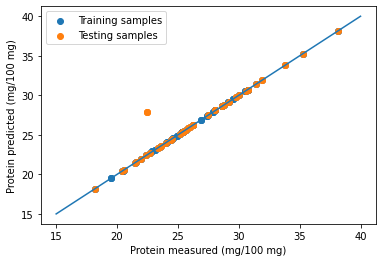

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.xlabel("Protein measured (mg/100 mg)") 
plt.ylabel("Protein predicted (mg/100 mg)") 
plt.scatter(y_train[:,0],y_pred_train[:,0])
plt.scatter(y_test[:,0], y_pred_test[:,0])
plt.legend(["Training samples", "Testing samples"], loc ="upper left") 
plt.plot([15,40],[15,40])  
plt.savefig('protein.pdf',bbox_inches='tight')

In [ ]:
#Some metrics
def huber(y_true, y_pred, delta=1.0):
	y_true = y_true.reshape(-1,1)
	y_pred = y_pred.reshape(-1,1)
	return np.mean(delta**2*( (1+((y_true-y_pred)/delta)**2)**0.5 -1))

In [ ]:
def benchmark(X_train,y_train,X_test, y_test, model):
    rmse = np.mean((y_train - pls2.predict(X_train).reshape(y_train.shape))**2)**0.5
    rmse_test = np.mean((y_test - pls2.predict(X_test).reshape(y_test.shape))**2)**0.5
    hub = huber(y_train, pls2.predict(X_train))
    hub_test = huber(y_test, pls2.predict(X_test))
    print ("RMSE  Train/Test\t%0.2F\t%0.2F"%(rmse, rmse_test))
    print ("Huber Train/Test\t%0.4F\t%0.4F"%(hub, hub_test))

In [ ]:
benchmark(X_train, y_train, X_test, y_test, pls2)

RMSE  Train/Test	11.66	11.89
Huber Train/Test	7.4175	7.5767
